In [1]:
import warnings
warnings.filterwarnings('ignore')
import math
import os
import random
import zipfile
import collections
import numpy as np
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

In [2]:
# Step 1: Download the data.
# 若還沒下載 text8.zip 可以輸入以下網址 : 'http://mattmahoney.net/dc/text8.zip'
filename = 'text8.zip'
f = zipfile.ZipFile(filename)
vocabulary = tf.compat.as_str(f.read(f.namelist()[0])).split()
print('Data size : {}'.format(len(vocabulary)))

Data size : 17005207


In [3]:
# Step 2: Build the dictionary and replace rare words with UNK token.

# 計算詞頻
count = {}
for word in vocabulary:
    if word in count.keys():
        count[word] += 1
    elif word not in count.keys():
        count[word] = 1
count = sorted(count.items() , key = lambda x : x[1] , reverse = True) # 由詞出現的次數由高排到低
count = [('UNK' , -1)] + count
vocabulary_size = 50000
count = count[:vocabulary_size] # 選出前50000個最常出現的詞

# 建立詞庫
vocab_to_int = {}
for i , word in enumerate(count):
    vocab_to_int[word[0]] = i
int_to_vocab = dict(zip(vocab_to_int.values() , vocab_to_int.keys()))

# 每vocabulary的每個詞映射為一個數字ID
data = []
unk_count = 0
for word in vocabulary:
    if word in vocab_to_int.keys():
        data.append(vocab_to_int[word])
    elif word not in vocab_to_int.keys():
        unk_count += 1 # 計算vocabulary中不在vocab_to_int的詞的樹木
        data.append(vocab_to_int['UNK']) 

count = [list(content) for content in count] # 改成list格式，方便改count裡面的值
count[0][1] = unk_count
del vocabulary  # Hint to reduce memory.
print('前5個最常出現的詞 : {}'.format(count[:5]))

前5個最常出現的詞 : [['UNK', 418391], ['the', 1061396], ['of', 593677], ['and', 416629], ['one', 411764]]


In [4]:
"""
選擇文本其中的 3 個詞，並選擇這3個詞的上文2個詞、下文2個詞

第 1 次訓練->
index : 0 , 1 , 2 
input_data:  data[0] , data[0] , data[1] , data[1] , data[1] , data[2] , data[2] , data[2] , data[2] 
output_data: data[1] , data[2] , data[0] , data[2] , data[3] , data[0] , data[1] , data[3] , data[4] 

第 2 次訓練->
index : 3 , 4 , 5
input_data:  data[3] , data[3] , data[3] , data[3] , data[4] , data[4] , data[4] , data[4] , data[5] , data[5] , data[5] , data[5] 
output_data: data[1] , data[2] , data[4] , data[5] , data[2] , data[3] , data[5] , data[6] , data[3] , data[4] , data[6] , data[7] 

第 3 次訓練->
index : 6 , 7 , 8
input_data:  data[6] , data[6] , data[6] , data[6] , data[7] , data[7] , data[7] , data[7] , data[8] , data[8] , data[8] , data[8] 
output_data: data[4] , data[5] , data[7] , data[8] , data[5] , data[6] , data[8] , data[9] , data[6] , data[7] , data[9] , data[10] 

.
.
.

第 334 次訓練->
index : 999 , 0 , 1
input_data:  data[999] , data[999] , data[0] , data[0] , data[1] , data[1] , data[1] 
output_data: data[997] , data[998] , data[1] , data[2] , data[0] , data[2] , data[3] 
"""

# Step 3: Function to generate a training batch for the skip-gram model.
# context_num_word : 決定窗口大小的數值
global index
index = collections.deque(np.arange(0 , len(data)))
data_ = np.array(data)
def generate_batch(batch_size , context_num_word):
    global index
    input_data = []    
    label = []
    for j in range(0 , batch_size): # 一個batch抓batch_size個詞，而一個詞最多會有context_num_word個上文、context_num_word個下文
        label_temp = np.arange(index[j] - context_num_word , index[j] + context_num_word + 1)
        label_temp = label_temp[label_temp >= 0]         # ex:在第1個詞前面不會有上文
        label_temp = label_temp[label_temp < len(index)] # ex:在第最後一個詞後面不會有下文
        label_temp = list(label_temp)
        label_temp.remove(index[j])
        label.extend(list(data_[np.array(label_temp)]))
        
        input_data_temp = []
        for _ in range(0 , len(label_temp)):
            input_data_temp.append(data_[index[j]])
        input_data.extend(input_data_temp)   
                    
    index.rotate(-batch_size) 
    
    return np.array(input_data) , np.expand_dims(np.array(label) , axis  = 1)

In [5]:
# Step 4: Build and train a skip-gram model.
batch_size = 130
context_num_word = 1  # How many words to consider left and right.
embedding_size = 128  # Dimension of the embedding vector.
num_sampled = 64      # Number of negative examples to sample.

valid_size = 16  # 查看一下與某個詞相似的前16個詞
valid_window = 100  
np.random.seed(0)
valid_examples = np.random.choice(valid_window , valid_size , replace = False)

# Input data.
with tf.variable_scope('inputs'):
    train_inputs = tf.placeholder(tf.int32 , shape = [None , ])
    train_labels = tf.placeholder(tf.int32 , shape = [None , 1])
    valid_dataset = tf.constant(valid_examples , dtype = tf.int32)

# Look up embeddings for inputs.
with tf.variable_scope('embeddings'):
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size , embedding_size] , -1.0 , 1.0))
    # 例如train_inputs第1個數字為'10'，代表是所有50000個詞中第10個詞，所以要從這50000個詞中，找出這第10個詞
    # 也就是50000組128維的向量(embeddings)中，把第10個字的128維的向量找出來
    embed = tf.nn.embedding_lookup(embeddings , train_inputs) 

# Construct the variables for the NCE loss
with tf.variable_scope('weights'):
    nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size , embedding_size],
                              stddev = 1.0 / math.sqrt(embedding_size)))
with tf.variable_scope('biases'):
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
# Explanation of the meaning of NCE loss : http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
# 若label的詞是"the"，那就把"the"當作正樣本(=>1)，另外再從所有詞中選num_sampled個詞當作負樣本(=>0)，這樣可以讓訓練的結果更快
with tf.variable_scope('loss'):
    loss = tf.reduce_mean(tf.nn.nce_loss(weights = nce_weights ,
                                         biases = nce_biases ,
                                         labels = train_labels ,
                                         inputs = embed ,
                                         num_sampled = num_sampled ,
                                         num_classes = vocabulary_size))
    
    
# Add the loss value as a scalar to summary.
tf.summary.scalar('loss' , loss)

# Construct the SGD optimizer using a learning rate of 1.0.
with tf.name_scope('optimizer'):
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)    

<img src="相似度.JPG" style="width:550px;height:280px;float:middle">

In [6]:
# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings) , axis = 1 , keep_dims = True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings , valid_dataset)

# normalized_embeddings裏頭每個詞嵌向量與valid_embeddings每個詞嵌向量做內積
# 但其實normalized_embeddings中的每一個向量都已經是單位向量，因此內積計算的結果其實就是兩個詞嵌向量的cos(夾角)
# similarity(m , n)，代表valid_embeddings中第m個詞與normalized_embeddings第n個詞的相似度
similarity = tf.matmul(valid_embeddings , normalized_embeddings , transpose_b = True)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [7]:
# Step 5: Begin training.
sess = tf.Session() 
merged = tf.summary.merge_all()
writer = tf.summary.FileWriter('logs/' , sess.graph)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

num_steps = 20000
average_loss = 0
for step in range(0 , num_steps):
    
    batch_inputs, batch_labels = generate_batch(batch_size , context_num_word)
    feed_dict = {train_inputs: batch_inputs , train_labels : batch_labels}

    _ , summary , loss_val = sess.run([optimizer , merged , loss] , feed_dict = feed_dict)
    
    average_loss += loss_val

    # Add returned summaries to writer in each step.
    writer.add_summary(summary, step)

    if step % 2000 == 0:
        if step > 0:
            average_loss = average_loss / 2000
        # The average loss is an estimate of the loss over the last 2000 batches.
        print('\nstep : {}'.format(step))
        print('Average loss : {} '.format(average_loss))
        average_loss = 0

    if step % 2000 == 0:
        similar = sess.run(similarity)      
        for i in range(0 , valid_size):
            valid_word = int_to_vocab[valid_examples[i]]
            top_k = 8  # number of nearest neighbors
            nearest = (-similar[i , :]).argsort()[0 : top_k + 1] # nearest : 第i個詞與corpus所有的詞的相似度由高排到低的index
            log_str = 'Nearest to {} : '.format(valid_word)
            
            close_word = []
            for k in range(0 , top_k):
                close_word.append(int_to_vocab[nearest[k]])
            log_str += ' , '.join(close_word)   
            
            print('=' * 90)    
            print(log_str)
            
# Write corresponding labels for the embeddings.
with open('logs' + '/metadata.tsv', 'w') as f:
    for i in range(0 , vocabulary_size):
        f.write(int_to_vocab[i] + '\n')

# Save the model for checkpoints.
saver.save(sess , './logs/' , global_step = step)

# Create a configuration for visualizing embeddings with the labels in TensorBoard.
config = projector.ProjectorConfig()
embedding_conf = config.embeddings.add()
embedding_conf.tensor_name = embeddings.name
embedding_conf.metadata_path = os.getcwd() + '//logs//metadata.tsv'
projector.visualize_embeddings(writer, config)

writer.close()            


step : 0
Average loss : 268.1336364746094 
Nearest to are : are , exmoor , entombed , auctions , locales , modernised , solomon , spaniard
Nearest to united : united , gra , irgun , futurist , cbm , being , travis , diputados
Nearest to of : of , shelton , vai , hillside , touristic , benhavn , linger , algardi
Nearest to such : such , grosse , grossing , variances , dara , bosnia , bust , equip
Nearest to d : d , executives , belli , logarithms , aeroflot , consulates , prentice , laramie
Nearest to often : often , fallacious , tu , dhole , skulls , tunnelling , surprisingly , reductio
Nearest to five : five , meld , genital , colophon , archimedes , coro , stringed , akan
Nearest to b : b , antagonism , macbook , superficially , prevailed , ampex , bartender , matrimonial
Nearest to been : been , suspend , claude , abuses , rearden , normans , colombia , mesogens
Nearest to so : so , miscellany , commenting , mary , relied , persuade , cleaved , antagonists
Nearest to can : can , ph


step : 6000
Average loss : 33.722859112262725 
Nearest to are : are , is , pottery , can , videos , mall , charges , solomon
Nearest to united : united , being , why , settled , romantic , successful , absurd , uniform
Nearest to of : of , and , in , institute , the , agrippina , remains , vs
Nearest to such : such , wave , merits , axiom , emigration , movement , characterized , failed
Nearest to d : d , terry , vilayet , berber , larger , mathematical , audi , movie
Nearest to often : often , there , tu , part , trust , surprisingly , criteria , foreign
Nearest to five : five , january , vs , essays , fox , tango , aryan , hostile
Nearest to b : b , macbook , certain , century , serving , prevailed , sworn , ludwig
Nearest to been : been , claude , scores , earth , colombia , industrial , algorithm , rearden
Nearest to so : so , mary , abduction , episode , time , superorder , chart , relied
Nearest to can : can , boys , gulf , establishment , terry , group , system , pseudo
Nearest


step : 12000
Average loss : 13.622928666949273 
Nearest to are : are , is , were , was , can , blair , pottery , congressman
Nearest to united : united , being , uniform , diet , settled , romantic , appendix , travis
Nearest to of : of , and , in , amaranthus , for , agrippina , nine , li
Nearest to such : such , merits , grosse , wave , expectations , emigration , bust , bosnia
Nearest to d : d , terry , one , larger , miss , berber , vilayet , mathematical
Nearest to often : often , there , tu , fallacious , acropolis , trust , skulls , surprisingly
Nearest to five : five , nine , antiprism , zero , vs , two , pigweed , archimedes
Nearest to b : b , macbook , ludwig , certain , prevailed , superficially , serving , sworn
Nearest to been : been , was , antiprism , abuses , nitrogen , industrial , colombia , scores
Nearest to so : so , mary , birkenau , abduction , relied , time , episode , persuade
Nearest to can : can , establishment , gulf , are , attention , may , pseudo , boys
N


step : 18000
Average loss : 8.41422463643551 
Nearest to are : are , were , is , was , can , purple , charges , congressman
Nearest to united : united , being , uniform , diet , and , travis , sparrow , settled
Nearest to of : of , and , in , for , nine , amaranthus , agrippina , zero
Nearest to such : such , gh , grossing , expectations , merits , grosse , dara , wave
Nearest to d : d , b , terry , miss , larger , berber , vilayet , mathematical
Nearest to often : often , there , tu , fallacious , default , trust , surprisingly , acropolis
Nearest to five : five , nine , zero , two , three , eight , antiprism , one
Nearest to b : b , d , ludwig , macbook , certain , superficially , vaginal , and
Nearest to been : been , was , abuses , antiprism , industrial , be , nitrogen , by
Nearest to so : so , mary , birkenau , beadwork , commenting , relied , abduction , time
Nearest to can : can , may , would , are , establishment , to , gulf , lucan
Nearest to system : system , assemblers , m

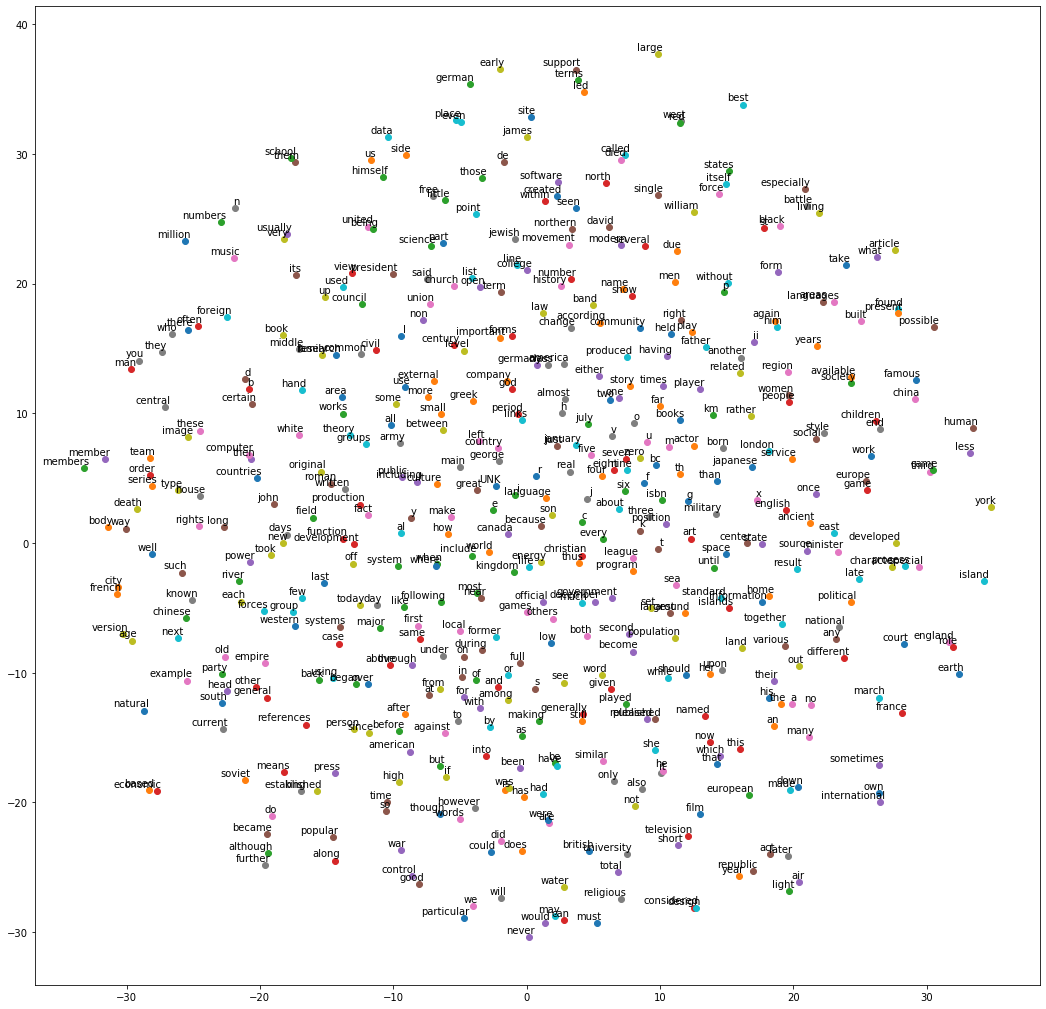

<Figure size 432x288 with 0 Axes>

In [10]:
# Step 6: Visualize the embeddings.
final_embeddings = sess.run(normalized_embeddings)

# pylint: disable=missing-docstring
# Function to draw visualization of distance between embeddings.
def plot_with_labels(low_dim_embs, labels, filename):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    plt.savefig(filename)
    
try:
    # pylint: disable=g-import-not-at-top
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(perplexity = 30 , n_components = 2 , init = 'pca' , n_iter = 5000 , method = 'exact')
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [int_to_vocab[i] for i in range(0 , plot_only)]
    plot_with_labels(low_dim_embs, labels, 'tsne.png')

except ImportError as ex:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')
    print(ex)    